In [16]:
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

In [5]:
WINDOW_SIZE = 4000
NUM_CHANNELS = 16
X_int = np.load("interictal_gan_train.npy")
X_int = X_int.reshape(-1, WINDOW_SIZE, NUM_CHANNELS)

In [6]:
X_int.shape

(9499, 4000, 16)

In [7]:
y_int = np.zeros((X_int.shape[0],))

In [8]:
y_int.shape

(9499,)

In [13]:
X_int_normalized = (X_int - X_int.min()) / (X_int.max() - X_int.min())

In [32]:
print("Min X for interictal =", X_int.min(), "\nMax X for interictal=", X_int.max())


Min X for interictal = -2153 
Max X for interictal= 1925


In [14]:
from sklearn.model_selection import train_test_split
X_int_train, X_int_val, y_int_train, y_int_val = train_test_split(X_int_normalized, y_int, test_size = 0.1, random_state=9)

In [29]:
print(X_int_train.shape, X_int_val.shape, y_int_train.shape, y_int_val.shape)

(8549, 4000, 16) (950, 4000, 16) (8549,) (950,)


# Define DDPM

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the Denoising Diffusion Probabilistic Model (DDPM)
class DDPM(nn.Module):
    def __init__(self, input_channels, num_filters):
        super(DDPM, self).__init__()
        
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv1d(input_channels, num_filters, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(num_filters, num_filters, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Conv1d(num_filters, num_filters, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(num_filters, input_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()  # Output range between 0 and 1
        )
        
    def forward(self, x):
        #encoded = self.encoder(x)
        encoded = self.encoder(x.permute(0, 2, 1))  # Permute to match Conv1d input format
        decoded = self.decoder(encoded)
        #return decoded
        return decoded.permute(0, 2, 1)  # Permute back to original shape

In [18]:
# Hyperparameters
input_channels = 16  # NUM_CHANNELS
num_filters = 32
batch_size = 64  # Batch size increased
learning_rate = 0.001 #learning rate increased
num_epochs = 25

In [19]:
# Convert training data to PyTorch tensors
X_train_tensor = torch.tensor(X_int_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_int_train, dtype=torch.float32)

# Convert validation data to PyTorch tensors
X_val_tensor = torch.tensor(X_int_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_int_val, dtype=torch.float32)

# Create DataLoader for training set
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create DataLoader for validation set
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # No need to shuffle validation data

In [21]:
# Initialize the model
model_interictal = DDPM(input_channels, num_filters)
criterion = nn.MSELoss()  # Mean Squared Error loss for reconstruction
optimizer = optim.Adam(model_interictal.parameters(), lr=learning_rate)

train_losses_interictal = []
val_losses_interictal = []

# Training loop
for epoch in range(num_epochs):
    # Training
    model_interictal.train()  # Set model to training mode
    for i, (batch_X, _) in enumerate(train_dataloader):
        
        # Forward pass
        reconstructed = model_interictal(batch_X)
        
        # Calculate loss
        loss = criterion(reconstructed, batch_X)
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Append losses to the lists after each epoch
        train_losses_interictal.append(loss.item())
        
        
        # Print progress
       # print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(dataloader)}], Loss: {loss.item()}")
        
        # Validation
        model_interictal.eval()  # Set model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():
            for batch_X_val, _ in val_dataloader:
                reconstructed_val = model_interictal(batch_X_val)
                val_loss += criterion(reconstructed_val, batch_X_val).item()
        val_loss /= len(val_dataloader)
        val_losses_interictal.append(val_loss)

        # Print training and validation loss
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item()}, Validation Loss: {val_loss}")


Epoch [1/25], Train Loss: 0.0010402239859104156, Validation Loss: 0.0008762090272891025
Epoch [1/25], Train Loss: 0.0007955128094181418, Validation Loss: 0.0007484551014689107
Epoch [1/25], Train Loss: 0.0008230623207055032, Validation Loss: 0.0006404953155045708
Epoch [1/25], Train Loss: 0.0006154373404569924, Validation Loss: 0.0005563614366110414
Epoch [1/25], Train Loss: 0.0005577924894168973, Validation Loss: 0.0004904925590381026
Epoch [1/25], Train Loss: 0.0004940288490615785, Validation Loss: 0.00043554057095510264
Epoch [1/25], Train Loss: 0.0004351685638539493, Validation Loss: 0.0003915241570211947
Epoch [1/25], Train Loss: 0.00043147013639099896, Validation Loss: 0.0003570062709817042
Epoch [1/25], Train Loss: 0.0003349939361214638, Validation Loss: 0.0003297903672015915
Epoch [1/25], Train Loss: 0.0003357651294209063, Validation Loss: 0.00030767111165914686
Epoch [1/25], Train Loss: 0.0002750115527305752, Validation Loss: 0.00028866416153808434
Epoch [1/25], Train Loss: 0.

Epoch [1/25], Train Loss: 0.0002499783877283335, Validation Loss: 0.00021346160404694576
Epoch [1/25], Train Loss: 0.0002660565951373428, Validation Loss: 0.00021325892012100667
Epoch [1/25], Train Loss: 0.00024923330056481063, Validation Loss: 0.00021303065004758538
Epoch [1/25], Train Loss: 0.00022081428323872387, Validation Loss: 0.00021279630212423702
Epoch [1/25], Train Loss: 0.00029712211107835174, Validation Loss: 0.00021254085198355217
Epoch [1/25], Train Loss: 0.0001807851658668369, Validation Loss: 0.00021226494767082234
Epoch [1/25], Train Loss: 0.00022951811843086034, Validation Loss: 0.0002119819720974192
Epoch [1/25], Train Loss: 0.00018803634156938642, Validation Loss: 0.00021168635382006566
Epoch [1/25], Train Loss: 0.00019735416572075337, Validation Loss: 0.00021136629026538383
Epoch [1/25], Train Loss: 0.0002638969453983009, Validation Loss: 0.00021105888202631226
Epoch [1/25], Train Loss: 0.00020691685494966805, Validation Loss: 0.00021072920450630286
Epoch [1/25], T

Epoch [2/25], Train Loss: 0.00018490299407858402, Validation Loss: 0.00016917341369359444
Epoch [2/25], Train Loss: 0.00021040529827587306, Validation Loss: 0.00016699241192933792
Epoch [2/25], Train Loss: 0.0001636797096580267, Validation Loss: 0.00016553376869220908
Epoch [2/25], Train Loss: 0.00020422303350642323, Validation Loss: 0.00016622823168290778
Epoch [2/25], Train Loss: 0.00017752779240254313, Validation Loss: 0.00016657264398721358
Epoch [2/25], Train Loss: 0.00020763278007507324, Validation Loss: 0.0001656444796632665
Epoch [2/25], Train Loss: 0.00014934205682948232, Validation Loss: 0.0001640212756077138
Epoch [2/25], Train Loss: 0.00017022161046043038, Validation Loss: 0.00016271110022595772
Epoch [2/25], Train Loss: 0.00018257266492582858, Validation Loss: 0.0001622915447417957
Epoch [2/25], Train Loss: 0.00018186375382356346, Validation Loss: 0.00016263034873797248
Epoch [2/25], Train Loss: 0.00012909815995953977, Validation Loss: 0.00016352577028252806
Epoch [2/25], 

Epoch [3/25], Train Loss: 0.00014417745114769787, Validation Loss: 0.00011950384262794008
Epoch [3/25], Train Loss: 0.0001315661211265251, Validation Loss: 0.00012455677788238972
Epoch [3/25], Train Loss: 0.00010506081889616325, Validation Loss: 0.00013519212176712851
Epoch [3/25], Train Loss: 0.00012263674580026418, Validation Loss: 0.0001308826923680802
Epoch [3/25], Train Loss: 0.0001100286899600178, Validation Loss: 0.0001191534169871981
Epoch [3/25], Train Loss: 0.00010774108523037285, Validation Loss: 0.0001227621299525102
Epoch [3/25], Train Loss: 0.00017005107656586915, Validation Loss: 0.00012784363304187233
Epoch [3/25], Train Loss: 0.00012181913916720077, Validation Loss: 0.00012296659260755405
Epoch [3/25], Train Loss: 0.00012565968791022897, Validation Loss: 0.00011842311408448344
Epoch [3/25], Train Loss: 0.00011046593863284215, Validation Loss: 0.00012214138841954992
Epoch [3/25], Train Loss: 0.00010508347622817382, Validation Loss: 0.000124270589731168
Epoch [3/25], Tra

Epoch [3/25], Train Loss: 0.0001137402214226313, Validation Loss: 0.00011009518008601542
Epoch [3/25], Train Loss: 0.0001058712659869343, Validation Loss: 0.00011004196324696144
Epoch [3/25], Train Loss: 0.00011359116615494713, Validation Loss: 0.000110021778770412
Epoch [3/25], Train Loss: 0.00010808186198119074, Validation Loss: 0.00011004476255038753
Epoch [3/25], Train Loss: 0.00010523015225771815, Validation Loss: 0.00010999166794742146
Epoch [3/25], Train Loss: 0.00010861183545785025, Validation Loss: 0.00010985797950221846
Epoch [3/25], Train Loss: 0.00013755427789874375, Validation Loss: 0.00010972186816312993
Epoch [3/25], Train Loss: 0.00011116177483927459, Validation Loss: 0.00010970235113442565
Epoch [3/25], Train Loss: 8.53046658448875e-05, Validation Loss: 0.00010966652383406958
Epoch [3/25], Train Loss: 9.395927918376401e-05, Validation Loss: 0.00010965577772973727
Epoch [3/25], Train Loss: 0.00012523031909950078, Validation Loss: 0.00010964851680910215
Epoch [3/25], Tra

Epoch [4/25], Train Loss: 0.00011394247121643275, Validation Loss: 0.00010475924257965137
Epoch [4/25], Train Loss: 0.00012633579899556935, Validation Loss: 0.0001043075739289634
Epoch [4/25], Train Loss: 9.195754682878032e-05, Validation Loss: 0.00010337517305742949
Epoch [4/25], Train Loss: 0.0001017934555420652, Validation Loss: 0.00010329400975024327
Epoch [4/25], Train Loss: 0.0001383957569487393, Validation Loss: 0.00010378691270792235
Epoch [4/25], Train Loss: 0.00011704017379088327, Validation Loss: 0.00010375018852452438
Epoch [4/25], Train Loss: 9.039417636813596e-05, Validation Loss: 0.00010315661153678471
Epoch [4/25], Train Loss: 9.434693492949009e-05, Validation Loss: 0.00010282416333211586
Epoch [4/25], Train Loss: 0.00011978577822446823, Validation Loss: 0.00010301312383186693
Epoch [4/25], Train Loss: 8.260364847956225e-05, Validation Loss: 0.00010304467238408203
Epoch [4/25], Train Loss: 0.00012631977733690292, Validation Loss: 0.00010279729855634893
Epoch [4/25], Tra

Epoch [5/25], Train Loss: 0.00010772898531286046, Validation Loss: 0.00010656752177358915
Epoch [5/25], Train Loss: 0.00013581549865193665, Validation Loss: 0.0001000615307323945
Epoch [5/25], Train Loss: 8.928009629016742e-05, Validation Loss: 9.76964157113495e-05
Epoch [5/25], Train Loss: 8.996260294225067e-05, Validation Loss: 0.0001006078760838136
Epoch [5/25], Train Loss: 9.113961277762428e-05, Validation Loss: 0.00010319474725595986
Epoch [5/25], Train Loss: 7.000500045251101e-05, Validation Loss: 0.00010186200767445067
Epoch [5/25], Train Loss: 0.00010311535879736766, Validation Loss: 9.83098681899719e-05
Epoch [5/25], Train Loss: 0.00010453691356815398, Validation Loss: 9.795309403367961e-05
Epoch [5/25], Train Loss: 0.00012834055814892054, Validation Loss: 0.00010010964469984174
Epoch [5/25], Train Loss: 7.4487914389465e-05, Validation Loss: 0.00010034361766884104
Epoch [5/25], Train Loss: 0.0001197162491735071, Validation Loss: 9.831467759795487e-05
Epoch [5/25], Train Loss: 

Epoch [5/25], Train Loss: 8.165485633071512e-05, Validation Loss: 9.686481304621945e-05
Epoch [5/25], Train Loss: 9.224276436725631e-05, Validation Loss: 9.725284908199683e-05
Epoch [5/25], Train Loss: 9.17275610845536e-05, Validation Loss: 9.740762276730189e-05
Epoch [5/25], Train Loss: 0.00010514683526707813, Validation Loss: 9.7519737513115e-05
Epoch [5/25], Train Loss: 8.509976760251448e-05, Validation Loss: 9.745120963392159e-05
Epoch [5/25], Train Loss: 0.00011609342618612573, Validation Loss: 9.690147465638196e-05
Epoch [5/25], Train Loss: 0.00010765586921479553, Validation Loss: 9.611818677512929e-05
Epoch [5/25], Train Loss: 7.921930955490097e-05, Validation Loss: 9.520906896796078e-05
Epoch [5/25], Train Loss: 8.929146861191839e-05, Validation Loss: 9.423546531858543e-05
Epoch [5/25], Train Loss: 8.80847655935213e-05, Validation Loss: 9.33739667137464e-05
Epoch [5/25], Train Loss: 0.00010540733637753874, Validation Loss: 9.285781513123463e-05
Epoch [5/25], Train Loss: 9.58027

Epoch [6/25], Train Loss: 9.022976155392826e-05, Validation Loss: 9.232081453471134e-05
Epoch [6/25], Train Loss: 9.333354682894424e-05, Validation Loss: 9.316006811180463e-05
Epoch [6/25], Train Loss: 0.00012011902435915545, Validation Loss: 9.325389692094177e-05
Epoch [6/25], Train Loss: 7.249040208989754e-05, Validation Loss: 9.248293693720673e-05
Epoch [6/25], Train Loss: 8.070795593084767e-05, Validation Loss: 9.14384116185829e-05
Epoch [6/25], Train Loss: 9.740758105181158e-05, Validation Loss: 9.093209422038248e-05
Epoch [6/25], Train Loss: 0.00011737801105482504, Validation Loss: 9.128430950416563e-05
Epoch [6/25], Train Loss: 0.00010084071254823357, Validation Loss: 9.206500447665652e-05
Epoch [6/25], Train Loss: 8.484474528813735e-05, Validation Loss: 9.250952425645664e-05
Epoch [6/25], Train Loss: 8.567638724343851e-05, Validation Loss: 9.237849056565513e-05
Epoch [6/25], Train Loss: 8.32526056910865e-05, Validation Loss: 9.17165923359183e-05
Epoch [6/25], Train Loss: 9.2698

Epoch [7/25], Train Loss: 8.644233457744122e-05, Validation Loss: 8.96642287746848e-05
Epoch [7/25], Train Loss: 8.645861089462414e-05, Validation Loss: 8.975848541012966e-05
Epoch [7/25], Train Loss: 0.00010146745626116171, Validation Loss: 8.98791348542242e-05
Epoch [7/25], Train Loss: 0.0001036413450492546, Validation Loss: 9.021874454144078e-05
Epoch [7/25], Train Loss: 8.535705273970962e-05, Validation Loss: 9.082190590561367e-05
Epoch [7/25], Train Loss: 9.71619738265872e-05, Validation Loss: 9.201157760495941e-05
Epoch [7/25], Train Loss: 9.244155808119103e-05, Validation Loss: 9.408855791358898e-05
Epoch [7/25], Train Loss: 0.00011588284542085603, Validation Loss: 9.790997185821955e-05
Epoch [7/25], Train Loss: 9.15727941901423e-05, Validation Loss: 0.00010435773923139398
Epoch [7/25], Train Loss: 9.56346484599635e-05, Validation Loss: 0.0001136127679880398
Epoch [7/25], Train Loss: 0.00013102144293952733, Validation Loss: 0.0001244986274590095
Epoch [7/25], Train Loss: 0.00012

Epoch [7/25], Train Loss: 0.00010364556510467082, Validation Loss: 8.916615285367394e-05
Epoch [7/25], Train Loss: 0.00010161101090488955, Validation Loss: 8.840932544747677e-05
Epoch [7/25], Train Loss: 6.838151603005826e-05, Validation Loss: 8.905422291718423e-05
Epoch [7/25], Train Loss: 8.739272743696347e-05, Validation Loss: 9.05623409683661e-05
Epoch [7/25], Train Loss: 8.800188516033813e-05, Validation Loss: 9.163008556546022e-05
Epoch [7/25], Train Loss: 9.309823508374393e-05, Validation Loss: 9.163605233576769e-05
Epoch [7/25], Train Loss: 9.903318277793005e-05, Validation Loss: 9.065761623787694e-05
Epoch [7/25], Train Loss: 8.792376320343465e-05, Validation Loss: 8.934928409871645e-05
Epoch [7/25], Train Loss: 6.684855907224119e-05, Validation Loss: 8.843624139747893e-05
Epoch [7/25], Train Loss: 7.919593917904422e-05, Validation Loss: 8.843083002526933e-05
Epoch [7/25], Train Loss: 8.280220936285332e-05, Validation Loss: 8.897553270799108e-05
Epoch [8/25], Train Loss: 9.474

Epoch [8/25], Train Loss: 0.000103343918453902, Validation Loss: 8.919064785004594e-05
Epoch [8/25], Train Loss: 0.00010087144619319588, Validation Loss: 8.763847169272292e-05
Epoch [8/25], Train Loss: 8.301732304971665e-05, Validation Loss: 8.837227578624151e-05
Epoch [8/25], Train Loss: 8.346459799213335e-05, Validation Loss: 8.893752844111684e-05
Epoch [8/25], Train Loss: 7.398548041237518e-05, Validation Loss: 8.777476784113483e-05
Epoch [8/25], Train Loss: 6.682574894512072e-05, Validation Loss: 8.7876727047842e-05
Epoch [8/25], Train Loss: 9.621501521905884e-05, Validation Loss: 8.920760786471268e-05
Epoch [8/25], Train Loss: 7.40522300475277e-05, Validation Loss: 8.874537670635618e-05
Epoch [8/25], Train Loss: 6.834361556684598e-05, Validation Loss: 8.789787631637106e-05
Epoch [8/25], Train Loss: 7.17286893632263e-05, Validation Loss: 8.880744668810318e-05
Epoch [8/25], Train Loss: 8.366728434339166e-05, Validation Loss: 8.861877940944397e-05
Epoch [8/25], Train Loss: 9.52513801

Epoch [9/25], Train Loss: 6.835609383415431e-05, Validation Loss: 9.418991588366528e-05
Epoch [9/25], Train Loss: 9.352022607345134e-05, Validation Loss: 9.680024231784046e-05
Epoch [9/25], Train Loss: 9.356778173241764e-05, Validation Loss: 9.769216558197513e-05
Epoch [9/25], Train Loss: 8.720892219571397e-05, Validation Loss: 9.694878050747017e-05
Epoch [9/25], Train Loss: 0.00010721671424107626, Validation Loss: 9.53091929356257e-05
Epoch [9/25], Train Loss: 8.853464532876387e-05, Validation Loss: 9.320533523956934e-05
Epoch [9/25], Train Loss: 7.653072680113837e-05, Validation Loss: 9.059601191741725e-05
Epoch [9/25], Train Loss: 0.00011757637548726052, Validation Loss: 8.845516761842494e-05
Epoch [9/25], Train Loss: 0.00010142884275410324, Validation Loss: 8.772486083519955e-05
Epoch [9/25], Train Loss: 6.58551580272615e-05, Validation Loss: 8.844178931515974e-05
Epoch [9/25], Train Loss: 7.634715439053252e-05, Validation Loss: 9.002755250548944e-05
Epoch [9/25], Train Loss: 6.125

Epoch [10/25], Train Loss: 0.0001002220087684691, Validation Loss: 8.51388744194992e-05
Epoch [10/25], Train Loss: 8.612476813141257e-05, Validation Loss: 8.542665964341722e-05
Epoch [10/25], Train Loss: 8.290968253277242e-05, Validation Loss: 8.563110629135432e-05
Epoch [10/25], Train Loss: 0.00010952678712783381, Validation Loss: 8.599862218640434e-05
Epoch [10/25], Train Loss: 9.5730836619623e-05, Validation Loss: 8.590200256245832e-05
Epoch [10/25], Train Loss: 8.175842958735302e-05, Validation Loss: 8.527939207851887e-05
Epoch [10/25], Train Loss: 0.00010564468539087102, Validation Loss: 8.496621012454852e-05
Epoch [10/25], Train Loss: 6.961942563066259e-05, Validation Loss: 8.478196759824641e-05
Epoch [10/25], Train Loss: 8.854553016135469e-05, Validation Loss: 8.483174751745537e-05
Epoch [10/25], Train Loss: 7.419446774292737e-05, Validation Loss: 8.495197107549757e-05
Epoch [10/25], Train Loss: 7.625663420185447e-05, Validation Loss: 8.600212483239981e-05
Epoch [10/25], Train L

Epoch [10/25], Train Loss: 8.331311983056366e-05, Validation Loss: 8.522448430691535e-05
Epoch [10/25], Train Loss: 7.630226173205301e-05, Validation Loss: 8.547989345970563e-05
Epoch [10/25], Train Loss: 0.00011137822002638131, Validation Loss: 8.603569513070397e-05
Epoch [10/25], Train Loss: 8.925522706704214e-05, Validation Loss: 8.649996452732011e-05
Epoch [10/25], Train Loss: 8.106447057798505e-05, Validation Loss: 8.71661245279635e-05
Epoch [10/25], Train Loss: 0.00011286779044894502, Validation Loss: 8.774495921291722e-05
Epoch [10/25], Train Loss: 6.71582092763856e-05, Validation Loss: 8.864276702903832e-05
Epoch [10/25], Train Loss: 9.13693438633345e-05, Validation Loss: 8.932284254115075e-05
Epoch [10/25], Train Loss: 8.879863889887929e-05, Validation Loss: 8.978485226786385e-05
Epoch [10/25], Train Loss: 9.433558443561196e-05, Validation Loss: 9.031452743026117e-05
Epoch [10/25], Train Loss: 7.830965478206053e-05, Validation Loss: 9.109026238244648e-05
Epoch [10/25], Train L

Epoch [11/25], Train Loss: 7.155015919124708e-05, Validation Loss: 7.811398851724032e-05
Epoch [11/25], Train Loss: 7.232195639517158e-05, Validation Loss: 7.804261913406663e-05
Epoch [11/25], Train Loss: 8.112326031550765e-05, Validation Loss: 7.797723834907326e-05
Epoch [11/25], Train Loss: 9.075064735952765e-05, Validation Loss: 7.791785828885623e-05
Epoch [11/25], Train Loss: 7.68026293371804e-05, Validation Loss: 7.78473722069369e-05
Epoch [11/25], Train Loss: 6.164357910165563e-05, Validation Loss: 7.7783359301975e-05
Epoch [11/25], Train Loss: 9.006342588691041e-05, Validation Loss: 7.772561487702963e-05
Epoch [11/25], Train Loss: 7.574028131784871e-05, Validation Loss: 7.767768790169308e-05
Epoch [11/25], Train Loss: 9.612864960217848e-05, Validation Loss: 7.767108957826471e-05
Epoch [11/25], Train Loss: 8.930702460929751e-05, Validation Loss: 7.756867053103633e-05
Epoch [11/25], Train Loss: 8.227860962506384e-05, Validation Loss: 7.751180819468573e-05
Epoch [11/25], Train Loss

Epoch [12/25], Train Loss: 7.465449016308412e-05, Validation Loss: 7.459175709906655e-05
Epoch [12/25], Train Loss: 7.643359276698902e-05, Validation Loss: 7.53808022030474e-05
Epoch [12/25], Train Loss: 7.512399315601215e-05, Validation Loss: 7.538248537457548e-05
Epoch [12/25], Train Loss: 6.089073576731607e-05, Validation Loss: 7.454159858752974e-05
Epoch [12/25], Train Loss: 6.163912621559575e-05, Validation Loss: 7.499303901568056e-05
Epoch [12/25], Train Loss: 9.481202141614631e-05, Validation Loss: 7.492727648544436e-05
Epoch [12/25], Train Loss: 6.840370770078152e-05, Validation Loss: 7.437660242430866e-05
Epoch [12/25], Train Loss: 6.419786950573325e-05, Validation Loss: 7.483344064288152e-05
Epoch [12/25], Train Loss: 8.804220124147832e-05, Validation Loss: 7.49541841893612e-05
Epoch [12/25], Train Loss: 9.472384408582002e-05, Validation Loss: 7.429585991000446e-05
Epoch [12/25], Train Loss: 8.898457599570975e-05, Validation Loss: 7.466050155926495e-05
Epoch [12/25], Train Lo

Epoch [12/25], Train Loss: 7.514847675338387e-05, Validation Loss: 7.223018959242229e-05
Epoch [12/25], Train Loss: 5.5755685025360435e-05, Validation Loss: 7.257193719851784e-05
Epoch [12/25], Train Loss: 8.366840484086424e-05, Validation Loss: 7.276198351367688e-05
Epoch [12/25], Train Loss: 5.563627928495407e-05, Validation Loss: 7.301235333822357e-05
Epoch [12/25], Train Loss: 6.527928780997172e-05, Validation Loss: 7.337457354879006e-05
Epoch [12/25], Train Loss: 6.26283508609049e-05, Validation Loss: 7.391097969957627e-05
Epoch [12/25], Train Loss: 0.00011078730312874541, Validation Loss: 7.441093912348151e-05
Epoch [12/25], Train Loss: 8.89153016032651e-05, Validation Loss: 7.440087235105845e-05
Epoch [12/25], Train Loss: 7.252518116729334e-05, Validation Loss: 7.371057945420035e-05
Epoch [12/25], Train Loss: 6.443273014156148e-05, Validation Loss: 7.298983303674808e-05
Epoch [12/25], Train Loss: 8.55772741488181e-05, Validation Loss: 7.240308793067621e-05
Epoch [12/25], Train L

Epoch [13/25], Train Loss: 8.707852975931019e-05, Validation Loss: 8.009780576685443e-05
Epoch [13/25], Train Loss: 8.155415707733482e-05, Validation Loss: 7.438263492076658e-05
Epoch [13/25], Train Loss: 8.102634456008673e-05, Validation Loss: 7.18991672329139e-05
Epoch [13/25], Train Loss: 6.66653795633465e-05, Validation Loss: 7.482278742827475e-05
Epoch [13/25], Train Loss: 8.068409078987315e-05, Validation Loss: 7.599649761687033e-05
Epoch [13/25], Train Loss: 7.221972191473469e-05, Validation Loss: 7.212372656795196e-05
Epoch [13/25], Train Loss: 7.031694985926151e-05, Validation Loss: 6.909614967298694e-05
Epoch [13/25], Train Loss: 5.312253051670268e-05, Validation Loss: 7.140674812641615e-05
Epoch [13/25], Train Loss: 7.35777139198035e-05, Validation Loss: 7.409675575521154e-05
Epoch [13/25], Train Loss: 5.925727964495309e-05, Validation Loss: 7.169099771999753e-05
Epoch [13/25], Train Loss: 8.51358927320689e-05, Validation Loss: 6.878524024311143e-05
Epoch [13/25], Train Loss

Epoch [14/25], Train Loss: 7.162138354033232e-05, Validation Loss: 6.653644013567827e-05
Epoch [14/25], Train Loss: 8.368184353457764e-05, Validation Loss: 6.608518669963815e-05
Epoch [14/25], Train Loss: 9.13817566470243e-05, Validation Loss: 6.60870377032552e-05
Epoch [14/25], Train Loss: 6.620007479796186e-05, Validation Loss: 6.620728114891487e-05
Epoch [14/25], Train Loss: 8.171875379048288e-05, Validation Loss: 6.641063664574176e-05
Epoch [14/25], Train Loss: 6.54762625345029e-05, Validation Loss: 6.654030051625645e-05
Epoch [14/25], Train Loss: 5.852359390701167e-05, Validation Loss: 6.65654491361541e-05
Epoch [14/25], Train Loss: 6.527798541355878e-05, Validation Loss: 6.653176727316653e-05
Epoch [14/25], Train Loss: 6.50278088869527e-05, Validation Loss: 6.63729188090656e-05
Epoch [14/25], Train Loss: 7.003619975876063e-05, Validation Loss: 6.617397884838283e-05
Epoch [14/25], Train Loss: 5.7401819503866136e-05, Validation Loss: 6.608820185647347e-05
Epoch [14/25], Train Loss:

Epoch [14/25], Train Loss: 4.8792244342621416e-05, Validation Loss: 6.323278915563909e-05
Epoch [14/25], Train Loss: 7.271313370438293e-05, Validation Loss: 6.321145046968013e-05
Epoch [14/25], Train Loss: 5.46892624697648e-05, Validation Loss: 6.319841365135896e-05
Epoch [14/25], Train Loss: 7.004170038271695e-05, Validation Loss: 6.299670688652744e-05
Epoch [14/25], Train Loss: 7.578188524348661e-05, Validation Loss: 6.301298077839116e-05
Epoch [14/25], Train Loss: 6.0878635849803686e-05, Validation Loss: 6.312281863453487e-05
Epoch [14/25], Train Loss: 5.791172952740453e-05, Validation Loss: 6.366853970879068e-05
Epoch [14/25], Train Loss: 7.648127939319238e-05, Validation Loss: 6.526126793081252e-05
Epoch [14/25], Train Loss: 7.058966002659872e-05, Validation Loss: 7.023977474697555e-05
Epoch [14/25], Train Loss: 7.32914631953463e-05, Validation Loss: 8.27518398485457e-05
Epoch [14/25], Train Loss: 8.458118099952117e-05, Validation Loss: 0.00010898178249287108
Epoch [14/25], Train 

Epoch [15/25], Train Loss: 5.8728437579702586e-05, Validation Loss: 6.291211951368799e-05
Epoch [15/25], Train Loss: 6.328478775685653e-05, Validation Loss: 6.383387711442387e-05
Epoch [15/25], Train Loss: 5.9973146562697366e-05, Validation Loss: 6.521196967999762e-05
Epoch [15/25], Train Loss: 8.408297435380518e-05, Validation Loss: 6.731418106937781e-05
Epoch [15/25], Train Loss: 8.022553811315447e-05, Validation Loss: 7.012025574416232e-05
Epoch [15/25], Train Loss: 6.680416845483705e-05, Validation Loss: 7.374748747679405e-05
Epoch [15/25], Train Loss: 7.560634549008682e-05, Validation Loss: 7.751138133850569e-05
Epoch [15/25], Train Loss: 6.29751812084578e-05, Validation Loss: 8.093494155521815e-05
Epoch [15/25], Train Loss: 7.320809527300298e-05, Validation Loss: 8.162202235932152e-05
Epoch [15/25], Train Loss: 8.793042798060924e-05, Validation Loss: 7.848633952865688e-05
Epoch [15/25], Train Loss: 8.07636315585114e-05, Validation Loss: 7.139474109862931e-05
Epoch [15/25], Train 

Epoch [16/25], Train Loss: 5.943299402133562e-05, Validation Loss: 6.155502802963989e-05
Epoch [16/25], Train Loss: 6.0866430430905893e-05, Validation Loss: 6.467993468201409e-05
Epoch [16/25], Train Loss: 6.677458441117778e-05, Validation Loss: 6.11922381115922e-05
Epoch [16/25], Train Loss: 6.3723637140356e-05, Validation Loss: 6.112290599655049e-05
Epoch [16/25], Train Loss: 7.599556556669995e-05, Validation Loss: 6.34257211155879e-05
Epoch [16/25], Train Loss: 7.48187376302667e-05, Validation Loss: 6.0704880888806655e-05
Epoch [16/25], Train Loss: 6.684922846034169e-05, Validation Loss: 6.06048182817176e-05
Epoch [16/25], Train Loss: 6.178124021971598e-05, Validation Loss: 6.251477413267518e-05
Epoch [16/25], Train Loss: 5.752106153522618e-05, Validation Loss: 6.0586152782586095e-05
Epoch [16/25], Train Loss: 5.709016477339901e-05, Validation Loss: 6.0143932205392045e-05
Epoch [16/25], Train Loss: 5.4014006309444085e-05, Validation Loss: 6.155684047068158e-05
Epoch [16/25], Train L

Epoch [16/25], Train Loss: 7.249255577335134e-05, Validation Loss: 6.224933919535639e-05
Epoch [16/25], Train Loss: 6.452044181060046e-05, Validation Loss: 5.980584125306147e-05
Epoch [16/25], Train Loss: 7.670083869015798e-05, Validation Loss: 6.16439045794929e-05
Epoch [16/25], Train Loss: 6.0128360928501934e-05, Validation Loss: 6.365813460433856e-05
Epoch [16/25], Train Loss: 6.0444501286838204e-05, Validation Loss: 6.257008450726668e-05
Epoch [16/25], Train Loss: 7.089572318363935e-05, Validation Loss: 5.999546895812576e-05
Epoch [16/25], Train Loss: 7.121537782950327e-05, Validation Loss: 5.975428624272657e-05
Epoch [17/25], Train Loss: 5.4284850193653256e-05, Validation Loss: 6.152299926422226e-05
Epoch [17/25], Train Loss: 5.1603958127088845e-05, Validation Loss: 6.189968407852576e-05
Epoch [17/25], Train Loss: 5.4487019951920956e-05, Validation Loss: 6.011971199768595e-05
Epoch [17/25], Train Loss: 5.095631058793515e-05, Validation Loss: 5.889707414704996e-05
Epoch [17/25], Tr

Epoch [17/25], Train Loss: 9.001541911857203e-05, Validation Loss: 6.018428636404375e-05
Epoch [17/25], Train Loss: 6.198089249664918e-05, Validation Loss: 6.712348476867191e-05
Epoch [17/25], Train Loss: 6.20599021203816e-05, Validation Loss: 8.368344084980587e-05
Epoch [17/25], Train Loss: 9.734792547533289e-05, Validation Loss: 7.83068052745269e-05
Epoch [17/25], Train Loss: 6.996042793616652e-05, Validation Loss: 6.200923938498211e-05
Epoch [17/25], Train Loss: 5.855285417055711e-05, Validation Loss: 6.377940032204303e-05
Epoch [17/25], Train Loss: 6.895766273373738e-05, Validation Loss: 7.279416992484281e-05
Epoch [17/25], Train Loss: 8.027566218515858e-05, Validation Loss: 6.660377451529105e-05
Epoch [17/25], Train Loss: 6.486675556516275e-05, Validation Loss: 5.993820862689366e-05
Epoch [17/25], Train Loss: 6.714409391861409e-05, Validation Loss: 6.592038480448536e-05
Epoch [17/25], Train Loss: 7.218491373350844e-05, Validation Loss: 6.628684811100053e-05
Epoch [17/25], Train Lo

Epoch [18/25], Train Loss: 5.936697925790213e-05, Validation Loss: 5.787859457389762e-05
Epoch [18/25], Train Loss: 5.1120645366609097e-05, Validation Loss: 5.788897494009386e-05
Epoch [18/25], Train Loss: 5.159479405847378e-05, Validation Loss: 5.7893499373070276e-05
Epoch [18/25], Train Loss: 4.9407502956455573e-05, Validation Loss: 5.788343890647714e-05
Epoch [18/25], Train Loss: 6.083631160436198e-05, Validation Loss: 5.787643070410316e-05
Epoch [18/25], Train Loss: 6.981030310271308e-05, Validation Loss: 5.787318295915611e-05
Epoch [18/25], Train Loss: 5.848983346368186e-05, Validation Loss: 5.7859924709191546e-05
Epoch [18/25], Train Loss: 4.472394357435405e-05, Validation Loss: 5.783842789242044e-05
Epoch [18/25], Train Loss: 5.634738408843987e-05, Validation Loss: 5.781698613039528e-05
Epoch [18/25], Train Loss: 6.314850907074288e-05, Validation Loss: 5.7818890248502915e-05
Epoch [18/25], Train Loss: 5.020709795644507e-05, Validation Loss: 5.7813431097504994e-05
Epoch [18/25], 

Epoch [19/25], Train Loss: 5.762761065852828e-05, Validation Loss: 5.928188523588081e-05
Epoch [19/25], Train Loss: 6.428759661503136e-05, Validation Loss: 5.784633904113434e-05
Epoch [19/25], Train Loss: 6.338679668260738e-05, Validation Loss: 5.8770433679455894e-05
Epoch [19/25], Train Loss: 5.181457891012542e-05, Validation Loss: 5.9934888607434304e-05
Epoch [19/25], Train Loss: 6.603538349736482e-05, Validation Loss: 5.959673023122984e-05
Epoch [19/25], Train Loss: 6.477245187852532e-05, Validation Loss: 5.8264816955973706e-05
Epoch [19/25], Train Loss: 5.6833538110367954e-05, Validation Loss: 5.800891788870407e-05
Epoch [19/25], Train Loss: 6.717177893733606e-05, Validation Loss: 5.8654011081671345e-05
Epoch [19/25], Train Loss: 6.659046630375087e-05, Validation Loss: 5.88209700557248e-05
Epoch [19/25], Train Loss: 5.650113234878518e-05, Validation Loss: 5.820401590123462e-05
Epoch [19/25], Train Loss: 7.53444546717219e-05, Validation Loss: 5.795102382156377e-05
Epoch [19/25], Tra

Epoch [19/25], Train Loss: 8.139984856825322e-05, Validation Loss: 8.626948450303946e-05
Epoch [19/25], Train Loss: 8.211240492528304e-05, Validation Loss: 7.769926863450867e-05
Epoch [19/25], Train Loss: 7.267093315022066e-05, Validation Loss: 6.564762249278525e-05
Epoch [19/25], Train Loss: 6.992190901655704e-05, Validation Loss: 5.8083776336085674e-05
Epoch [19/25], Train Loss: 5.579050775850192e-05, Validation Loss: 5.893309814079354e-05
Epoch [19/25], Train Loss: 5.8926867495756596e-05, Validation Loss: 6.462677605062102e-05
Epoch [19/25], Train Loss: 6.964668864384294e-05, Validation Loss: 6.761809806145417e-05
Epoch [19/25], Train Loss: 7.238565740408376e-05, Validation Loss: 6.41889081938037e-05
Epoch [19/25], Train Loss: 6.157890311442316e-05, Validation Loss: 5.888757829476769e-05
Epoch [19/25], Train Loss: 5.596181654254906e-05, Validation Loss: 5.775193252096263e-05
Epoch [19/25], Train Loss: 5.294923539622687e-05, Validation Loss: 6.087293271169377e-05
Epoch [19/25], Train

Epoch [20/25], Train Loss: 5.427128780866042e-05, Validation Loss: 5.693127677659504e-05
Epoch [20/25], Train Loss: 5.127452459419146e-05, Validation Loss: 5.695506212456773e-05
Epoch [20/25], Train Loss: 5.9759655414381996e-05, Validation Loss: 5.699210038680273e-05
Epoch [20/25], Train Loss: 6.429421773646027e-05, Validation Loss: 5.7027796234857915e-05
Epoch [20/25], Train Loss: 5.6470926210749894e-05, Validation Loss: 5.705333145063681e-05
Epoch [20/25], Train Loss: 5.99362792854663e-05, Validation Loss: 5.706994682744456e-05
Epoch [20/25], Train Loss: 6.115542782936245e-05, Validation Loss: 5.710429541068151e-05
Epoch [20/25], Train Loss: 4.3822779844049364e-05, Validation Loss: 5.716925588785671e-05
Epoch [20/25], Train Loss: 6.177755130920559e-05, Validation Loss: 5.7232844119425864e-05
Epoch [20/25], Train Loss: 5.446752766147256e-05, Validation Loss: 5.7298057557394105e-05
Epoch [20/25], Train Loss: 5.8658602938521653e-05, Validation Loss: 5.7373569385769464e-05
Epoch [20/25],

Epoch [21/25], Train Loss: 5.211631651036441e-05, Validation Loss: 5.672879318202225e-05
Epoch [21/25], Train Loss: 4.9829181079985574e-05, Validation Loss: 5.6701583525864406e-05
Epoch [21/25], Train Loss: 4.710346183856018e-05, Validation Loss: 5.667163083368602e-05
Epoch [21/25], Train Loss: 5.8164307120023295e-05, Validation Loss: 5.663203191943467e-05
Epoch [21/25], Train Loss: 6.201080395840108e-05, Validation Loss: 5.661314911170242e-05
Epoch [21/25], Train Loss: 6.705732812406495e-05, Validation Loss: 5.661738687194884e-05
Epoch [21/25], Train Loss: 5.9432619309518486e-05, Validation Loss: 5.666747674695216e-05
Epoch [21/25], Train Loss: 5.600712029263377e-05, Validation Loss: 5.6738605780992654e-05
Epoch [21/25], Train Loss: 6.108180241426453e-05, Validation Loss: 5.684557860755982e-05
Epoch [21/25], Train Loss: 5.5830765631981194e-05, Validation Loss: 5.699112080037594e-05
Epoch [21/25], Train Loss: 4.9607806431595236e-05, Validation Loss: 5.7168385925857974e-05
Epoch [21/25]

Epoch [21/25], Train Loss: 5.922242417000234e-05, Validation Loss: 5.689830625973021e-05
Epoch [21/25], Train Loss: 4.6831606596242636e-05, Validation Loss: 5.705291502332936e-05
Epoch [21/25], Train Loss: 4.7755322157172486e-05, Validation Loss: 5.730965009812886e-05
Epoch [21/25], Train Loss: 5.1896691729780287e-05, Validation Loss: 5.758436163887382e-05
Epoch [21/25], Train Loss: 4.903720400761813e-05, Validation Loss: 5.804048923891969e-05
Epoch [21/25], Train Loss: 4.651434937841259e-05, Validation Loss: 5.864472962760677e-05
Epoch [21/25], Train Loss: 6.202301301527768e-05, Validation Loss: 5.9522654191823675e-05
Epoch [21/25], Train Loss: 4.84140073240269e-05, Validation Loss: 6.0457338501388826e-05
Epoch [21/25], Train Loss: 5.543052247958258e-05, Validation Loss: 6.173558043277201e-05
Epoch [21/25], Train Loss: 5.927245001657866e-05, Validation Loss: 6.306767002873433e-05
Epoch [21/25], Train Loss: 7.934918539831415e-05, Validation Loss: 6.434111928683705e-05
Epoch [21/25], Tr

Epoch [22/25], Train Loss: 5.314150621416047e-05, Validation Loss: 5.616470104238639e-05
Epoch [22/25], Train Loss: 4.9865055189002305e-05, Validation Loss: 5.608648765094889e-05
Epoch [22/25], Train Loss: 5.134781531523913e-05, Validation Loss: 5.612839013338089e-05
Epoch [22/25], Train Loss: 5.096265158499591e-05, Validation Loss: 5.623487159027718e-05
Epoch [22/25], Train Loss: 5.156159750185907e-05, Validation Loss: 5.631781556682351e-05
Epoch [22/25], Train Loss: 5.848355431226082e-05, Validation Loss: 5.632748749728004e-05
Epoch [22/25], Train Loss: 4.940255166729912e-05, Validation Loss: 5.62651184736751e-05
Epoch [22/25], Train Loss: 7.318790449062362e-05, Validation Loss: 5.6187098137646294e-05
Epoch [22/25], Train Loss: 6.168452091515064e-05, Validation Loss: 5.616146396884384e-05
Epoch [22/25], Train Loss: 6.005328395985998e-05, Validation Loss: 5.618483531482828e-05
Epoch [22/25], Train Loss: 5.8150686527369544e-05, Validation Loss: 5.6207155770001314e-05
Epoch [22/25], Tra

Epoch [23/25], Train Loss: 5.831519956700504e-05, Validation Loss: 5.6368719621483855e-05
Epoch [23/25], Train Loss: 6.211028812685981e-05, Validation Loss: 5.641555253532715e-05
Epoch [23/25], Train Loss: 5.7285713410237804e-05, Validation Loss: 5.642435086580614e-05
Epoch [23/25], Train Loss: 5.0128321163356304e-05, Validation Loss: 5.642612134882559e-05
Epoch [23/25], Train Loss: 6.285143172135577e-05, Validation Loss: 5.644552802550606e-05
Epoch [23/25], Train Loss: 5.7881490647559986e-05, Validation Loss: 5.649311909413276e-05
Epoch [23/25], Train Loss: 5.897306255064905e-05, Validation Loss: 5.6619812676217406e-05
Epoch [23/25], Train Loss: 6.208736886037514e-05, Validation Loss: 5.6854742918706806e-05
Epoch [23/25], Train Loss: 6.551487604156137e-05, Validation Loss: 5.708791747262391e-05
Epoch [23/25], Train Loss: 5.011964094592258e-05, Validation Loss: 5.737235599857134e-05
Epoch [23/25], Train Loss: 4.614489444065839e-05, Validation Loss: 5.7786161293430874e-05
Epoch [23/25],

Epoch [23/25], Train Loss: 5.6327811762457713e-05, Validation Loss: 5.824343000616257e-05
Epoch [23/25], Train Loss: 6.78987562423572e-05, Validation Loss: 5.732970482010084e-05
Epoch [23/25], Train Loss: 6.275223131524399e-05, Validation Loss: 5.675878613449944e-05
Epoch [23/25], Train Loss: 5.869293454452418e-05, Validation Loss: 5.677165706098701e-05
Epoch [23/25], Train Loss: 5.3720457799499854e-05, Validation Loss: 5.72042884111094e-05
Epoch [23/25], Train Loss: 5.9006437368225306e-05, Validation Loss: 5.762322810672534e-05
Epoch [23/25], Train Loss: 4.901441570837051e-05, Validation Loss: 5.7747521592924994e-05
Epoch [23/25], Train Loss: 6.0215072153368965e-05, Validation Loss: 5.746435417677276e-05
Epoch [23/25], Train Loss: 6.239394133444875e-05, Validation Loss: 5.695621463625381e-05
Epoch [23/25], Train Loss: 6.823435251135379e-05, Validation Loss: 5.650981135355929e-05
Epoch [23/25], Train Loss: 5.762502405559644e-05, Validation Loss: 5.6401642602092276e-05
Epoch [23/25], Tr

Epoch [24/25], Train Loss: 6.850996578577906e-05, Validation Loss: 5.669467524664166e-05
Epoch [24/25], Train Loss: 4.463081495487131e-05, Validation Loss: 5.633985468496879e-05
Epoch [24/25], Train Loss: 6.012902667862363e-05, Validation Loss: 5.5985793490738915e-05
Epoch [24/25], Train Loss: 5.7602515880716965e-05, Validation Loss: 5.5777588810694095e-05
Epoch [24/25], Train Loss: 5.094773223390803e-05, Validation Loss: 5.5847700908392045e-05
Epoch [24/25], Train Loss: 5.445746501209214e-05, Validation Loss: 5.6084516836563124e-05
Epoch [24/25], Train Loss: 4.910232746624388e-05, Validation Loss: 5.624193217954598e-05
Epoch [24/25], Train Loss: 5.459988096845336e-05, Validation Loss: 5.6124931385663025e-05
Epoch [24/25], Train Loss: 6.546824442921206e-05, Validation Loss: 5.580195938819088e-05
Epoch [24/25], Train Loss: 5.223585321800783e-05, Validation Loss: 5.552856091526337e-05
Epoch [24/25], Train Loss: 6.24274616711773e-05, Validation Loss: 5.549628379715917e-05
Epoch [24/25], T

Epoch [25/25], Train Loss: 5.816968405270018e-05, Validation Loss: 5.7775163683497036e-05
Epoch [25/25], Train Loss: 6.152681453386322e-05, Validation Loss: 5.758374196981701e-05
Epoch [25/25], Train Loss: 5.983585288049653e-05, Validation Loss: 5.6711343980471914e-05
Epoch [25/25], Train Loss: 4.991422247258015e-05, Validation Loss: 5.582578936203693e-05
Epoch [25/25], Train Loss: 5.54166836082004e-05, Validation Loss: 5.542446572993261e-05
Epoch [25/25], Train Loss: 5.3450625273399055e-05, Validation Loss: 5.555111468614389e-05
Epoch [25/25], Train Loss: 6.695427146041766e-05, Validation Loss: 5.59318381419871e-05
Epoch [25/25], Train Loss: 6.529378879349679e-05, Validation Loss: 5.614628195568609e-05
Epoch [25/25], Train Loss: 6.504383782157674e-05, Validation Loss: 5.606142779773412e-05
Epoch [25/25], Train Loss: 4.442527279024944e-05, Validation Loss: 5.567064872593619e-05
Epoch [25/25], Train Loss: 6.0230919189052656e-05, Validation Loss: 5.5315386028572296e-05
Epoch [25/25], Tra

Epoch [25/25], Train Loss: 6.203261000337079e-05, Validation Loss: 6.031295730887602e-05
Epoch [25/25], Train Loss: 5.153420352144167e-05, Validation Loss: 5.765739285076658e-05
Epoch [25/25], Train Loss: 5.460621468955651e-05, Validation Loss: 5.586810463379758e-05
Epoch [25/25], Train Loss: 6.070879680919461e-05, Validation Loss: 5.7349351360850655e-05
Epoch [25/25], Train Loss: 5.1812708989018574e-05, Validation Loss: 5.8213162992615254e-05
Epoch [25/25], Train Loss: 4.8540186980972067e-05, Validation Loss: 5.63667500197577e-05
Epoch [25/25], Train Loss: 7.412581180687994e-05, Validation Loss: 5.504330959714328e-05
Epoch [25/25], Train Loss: 6.331766780931503e-05, Validation Loss: 5.623600542700539e-05
Epoch [25/25], Train Loss: 6.034391844877973e-05, Validation Loss: 5.728368923882954e-05
Epoch [25/25], Train Loss: 5.6304019381059334e-05, Validation Loss: 5.610270406274746e-05
Epoch [25/25], Train Loss: 5.314371082931757e-05, Validation Loss: 5.49367713877776e-05
Epoch [25/25], Tra

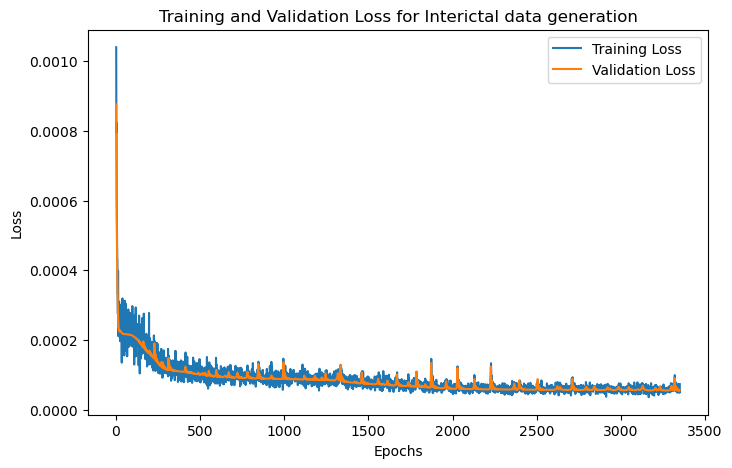

In [31]:
import matplotlib.pyplot as plt

# train_losses_interictal and val_losses_interictal contain the loss values across epochs
# Plotting training and validation loss
epochs = range(1, len(train_losses_interictal) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses_interictal, label='Training Loss')
plt.plot(epochs, val_losses_interictal, label='Validation Loss')
plt.title('Training and Validation Loss for Interictal data generation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('DDPM_interictal.png')
plt.show()

In [25]:
# Generate synthetic data samples
num_samples_to_generate = 2714
with torch.no_grad():
    generated_samples_interictal = []
    for _ in range(num_samples_to_generate):
        noise = torch.randn(1, X_int.shape[1], 32)  # Generate noise with 32 channels
        generated = model_interictal.decoder(noise.permute(0, 2, 1)).squeeze().numpy()  # Adjust input shape for the decoder
        generated_samples_interictal.append(generated)

# Convert generated samples to a NumPy array
generated_samples_interictal = np.array(generated_samples_interictal)

In [26]:
generated_samples_interictal.shape

(2714, 16, 4000)

In [27]:
np.save('generated_samples_interictal', generated_samples_interictal)

In [28]:
np.save('X_train_samples_interictal', X_int_train)
np.save('y_train_samples_interictal', y_int_train)
np.save('X_val_samples_interictal', X_int_val)
np.save('y_val_samples_interictal', y_int_val)